#Integrated Gradients, GradientShap, Occlusion, NoiseTunnel

This Jupyter Notebook starts by importing the necessary Python libraries such as Torch, Torchvision, PIL, requests, NumPy, and Captum.

This Jupyter notebook is based on:

* https://captum.ai/docs/attribution_algorithms#gradient-shap


#### Installing Captum Library

The following line installs version 0.6.0 of the Captum library.

This version is used because it is compatible with the other libraries used in this notebook.

In [ ]:
!pip install matplotlib==3.6 captum==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


#### Configuring Matplotlib for Displaying Images

The following line configures Matplotlib to display images without padding.

This configuration is necessary because Matplotlib adds padding around images by default, which can affect the layout of the notebook. Setting the `bbox_inches` parameter to `None` removes the padding and ensures that images are displayed at their original size without any cropping or scaling.

In [ ]:
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

#### Using Integrated Gradients, GradientShap, Occlusion, NoiseTunnel
This cell imports necessary libraries and loads a pre-trained VGG11 model for image classification. It applies different attribution methods like Integrated Gradients, GradientShap, and Occlusion to visualize important features of an input image for classification. The script also checks if a GPU is available, defines a baseline for some attribution methods, and smoothens the attribution maps using NoiseTunnel.

Using device: cpu


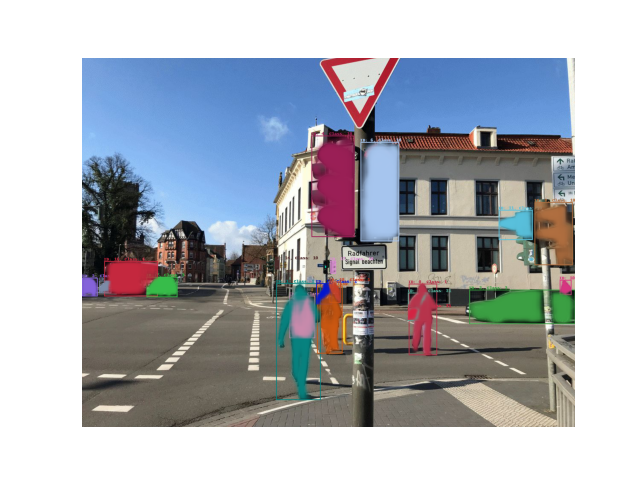

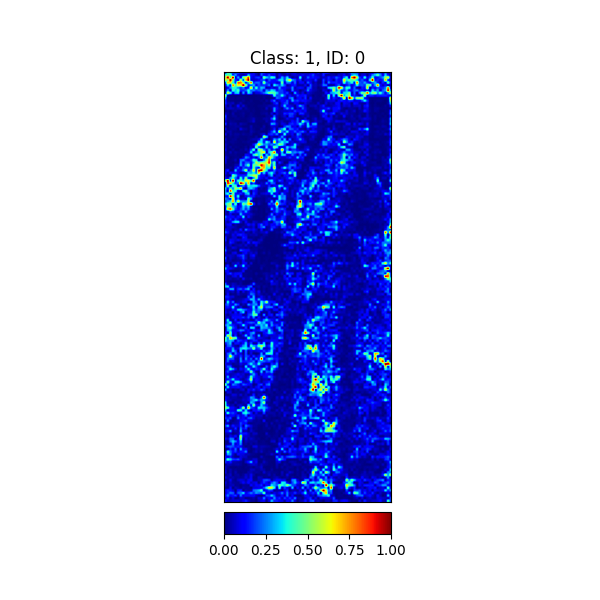

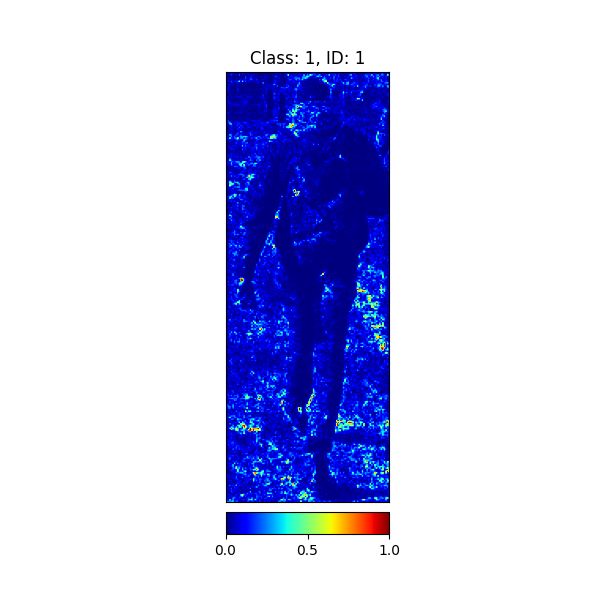

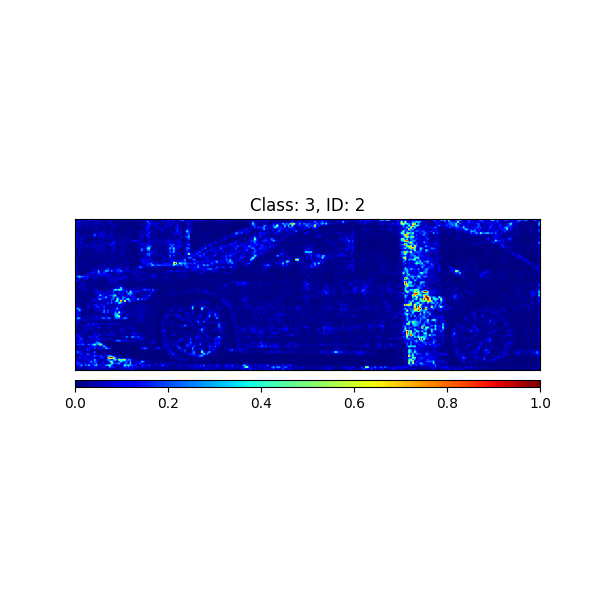

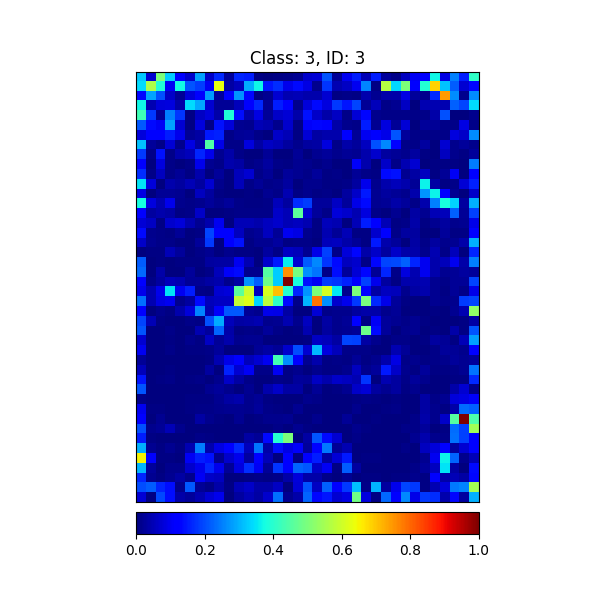

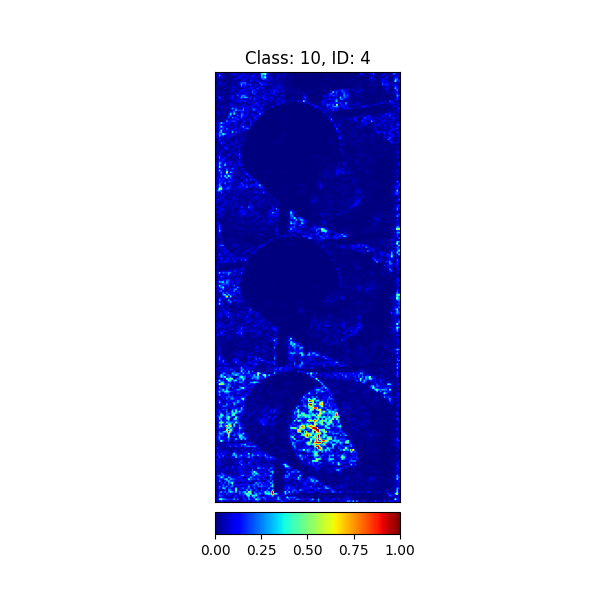

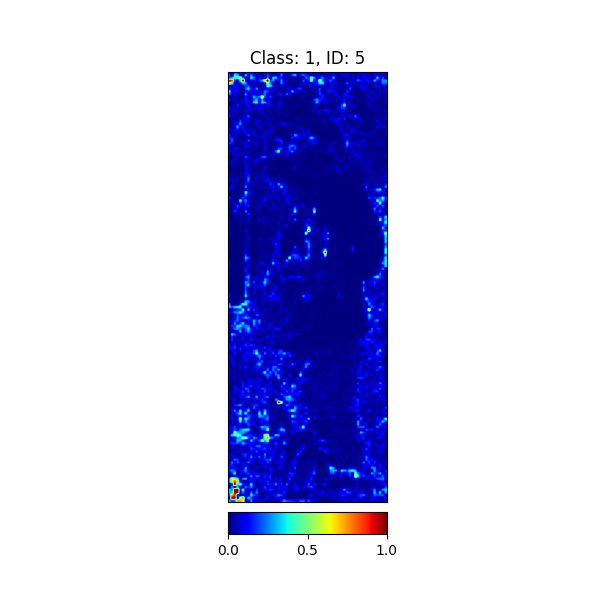

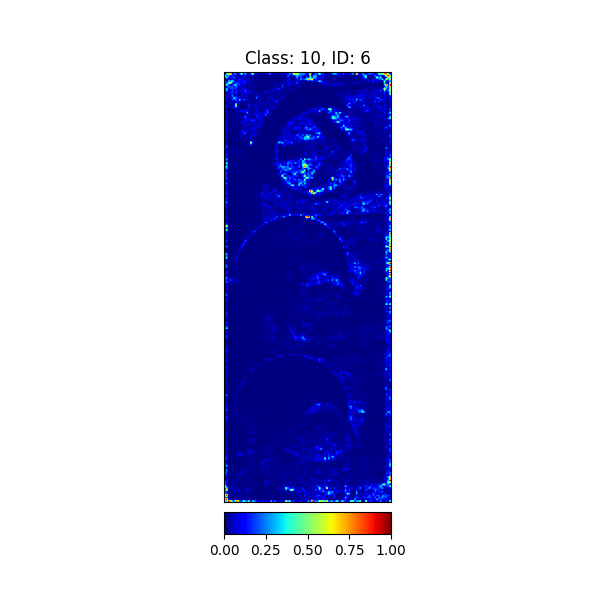

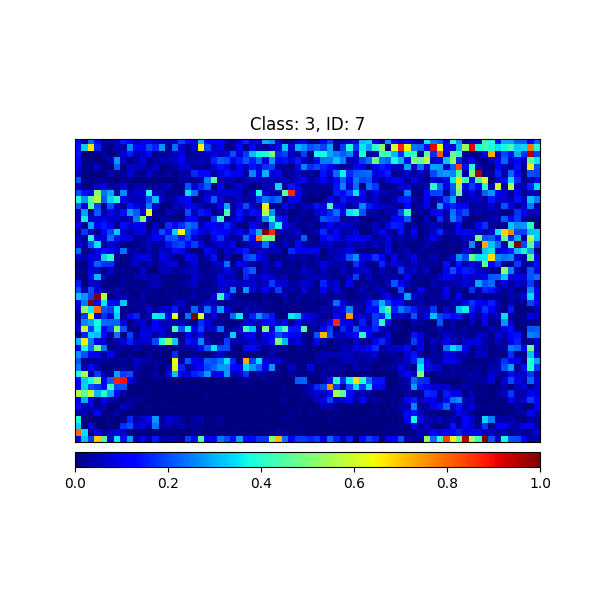

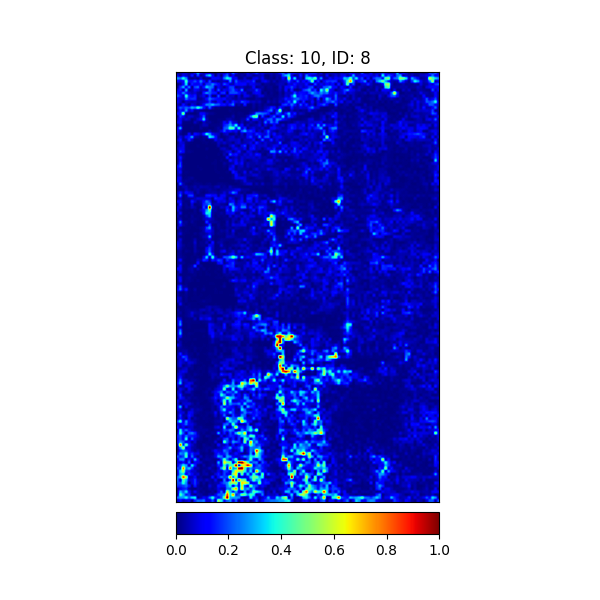

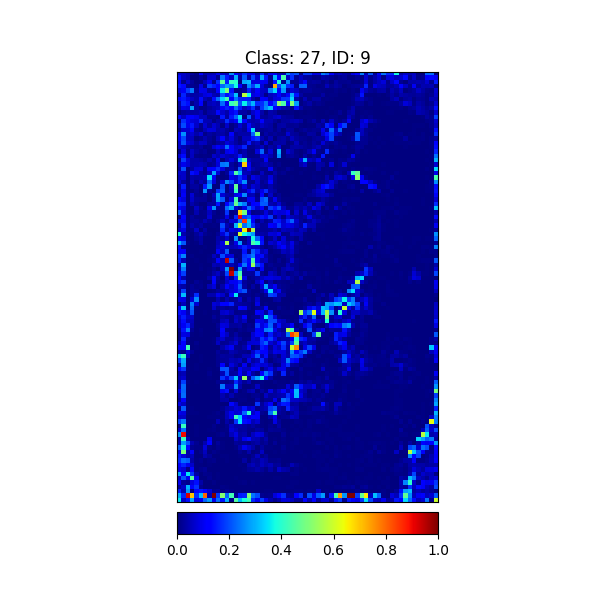

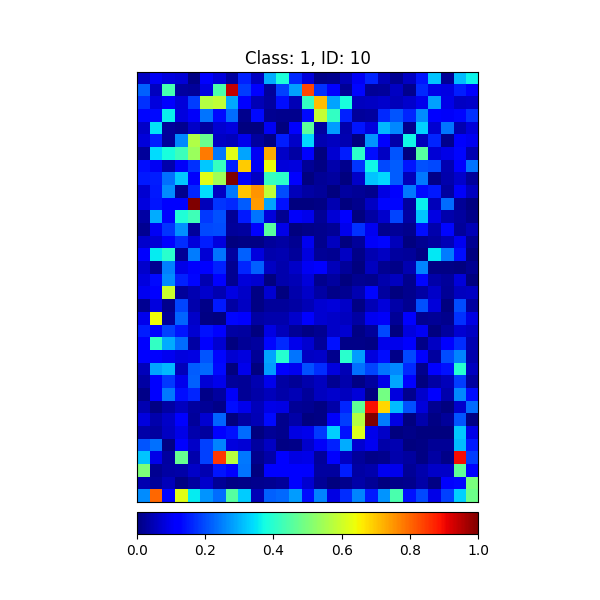

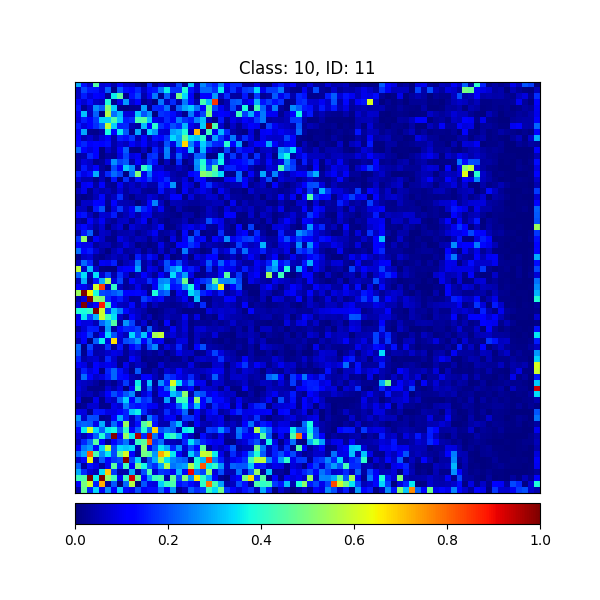

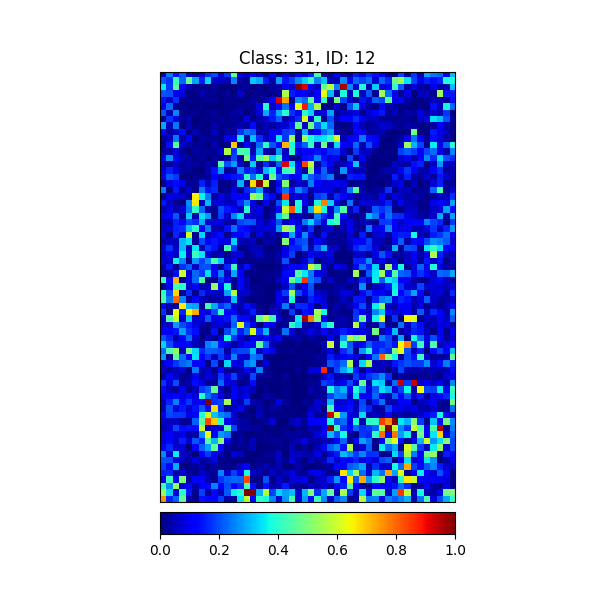

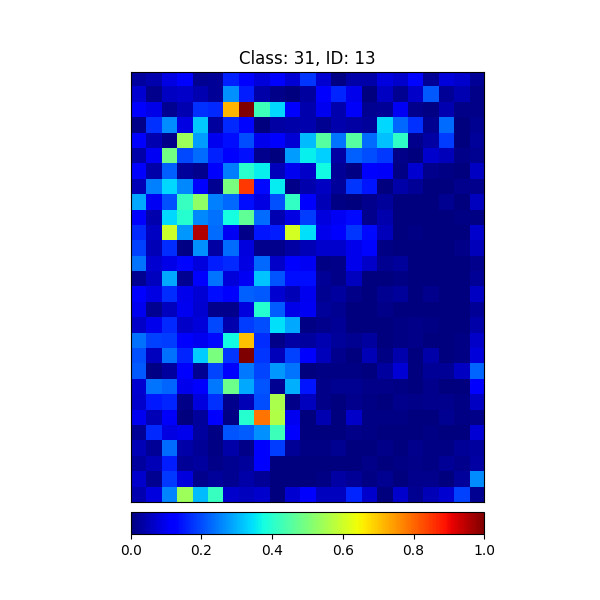

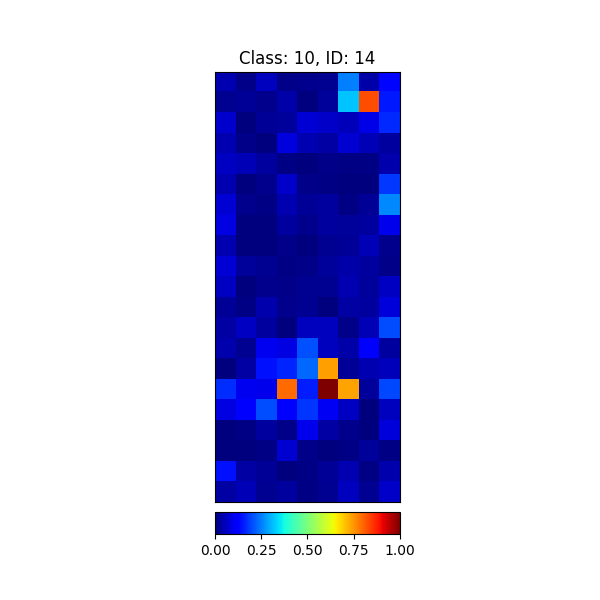

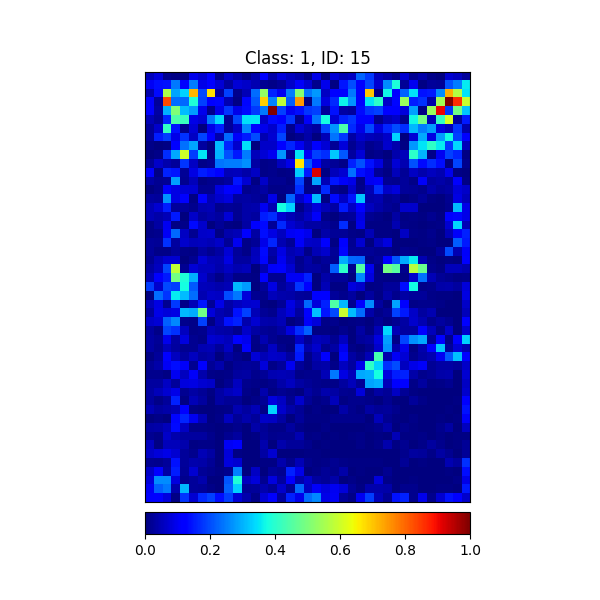

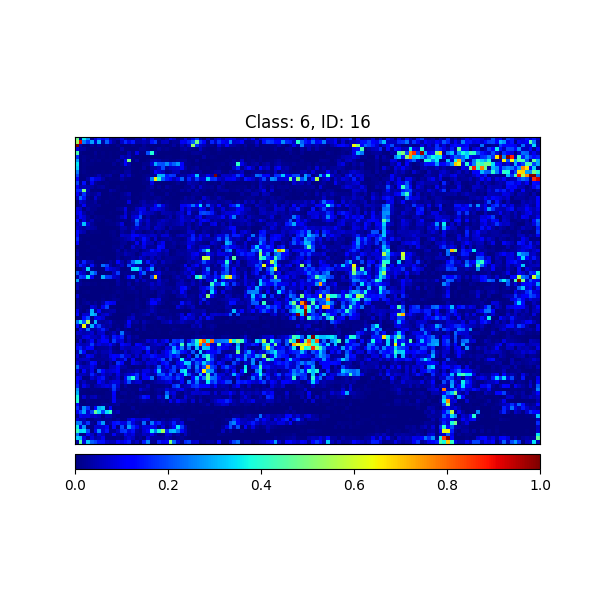

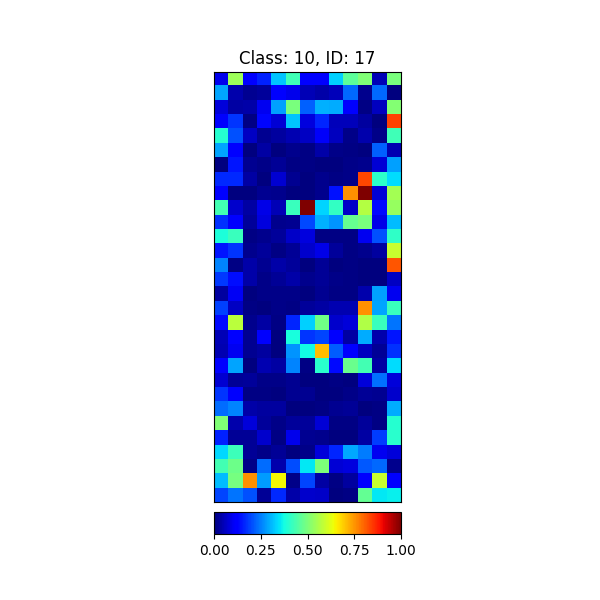

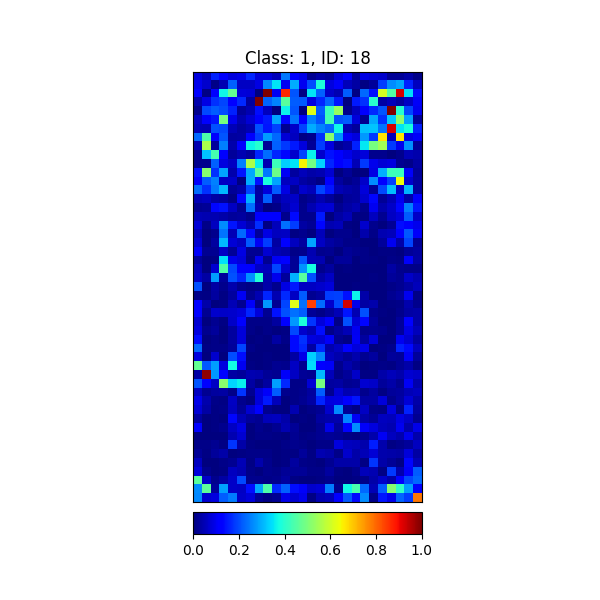

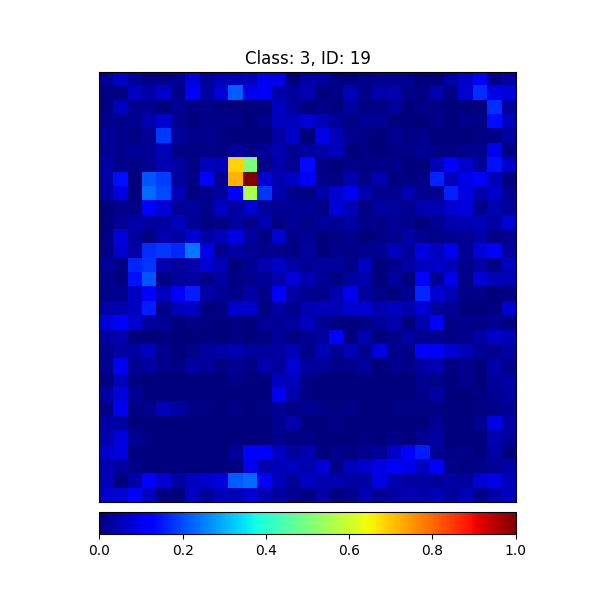

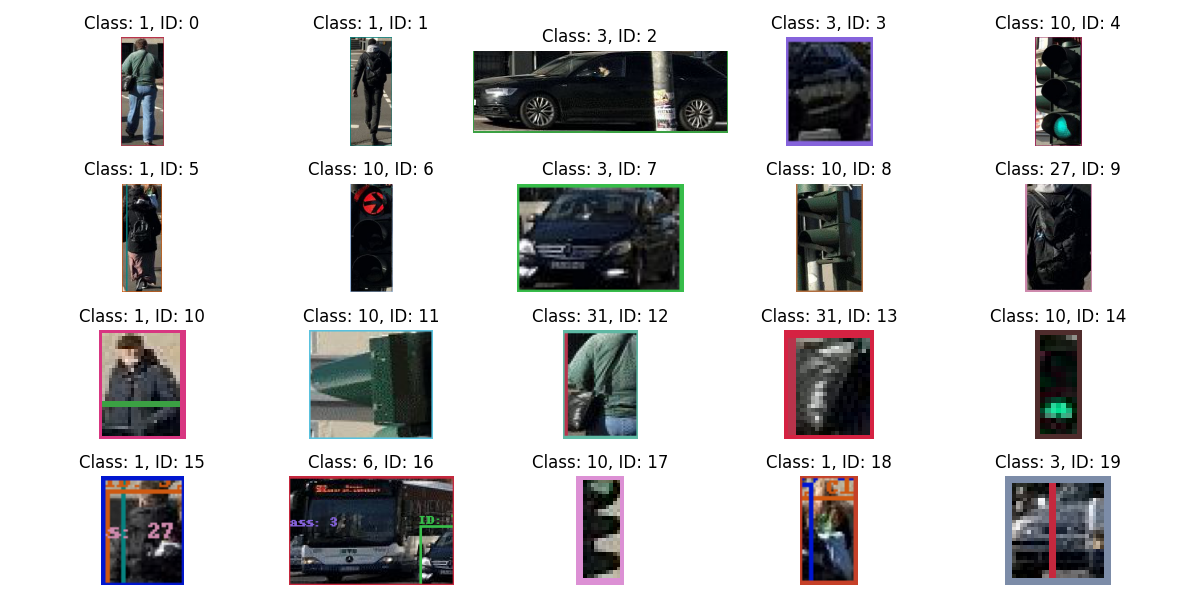

In [31]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models import resnet50
from captum.attr import GradientShap
from captum.attr import visualization as viz

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

# Load the pre-trained Mask R-CNN ResNet-50 model for instance segmentation
instance_model = maskrcnn_resnet50_fpn(pretrained=True)
instance_model.to(device)
instance_model.eval()

# Load the pre-trained ResNet-50 model for classification
classification_model = resnet50(pretrained=True)
classification_model.to(device)
classification_model.eval()

# Define the input image
image_path = '/content/drive/MyDrive/Colab Notebooks/images/multiple_tl.jpg'  # Update with your image path
img = Image.open(image_path).convert("RGB")
img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)

# Perform instance segmentation using the Mask R-CNN model
with torch.no_grad():
    predictions = instance_model(img_tensor)

# Retrieve the top 20 predicted masks, labels, and bounding boxes
top_k = min(20, predictions[0]['masks'].shape[0])
masks = predictions[0]['masks'][:top_k].detach().cpu().numpy()
labels = predictions[0]['labels'][:top_k].detach().cpu().numpy()
boxes = predictions[0]['boxes'][:top_k].detach().cpu().numpy()

# Create a blank image with RGBA mode
img_overlay = Image.new("RGBA", img.size)

# Initialize a list to store the cropped images
cropped_images = []

# Overlay the colored masks and bounding boxes on the original image
for i in range(masks.shape[0]):
    mask = masks[i, 0]  # Select the mask for the current instance
    label = labels[i]  # Select the label for the current instance
    box = boxes[i]  # Select the bounding box for the current instance

    # Generate a unique color for the current detection
    color = tuple(np.random.randint(0, 256, 3))

    # Convert the mask to PIL Image
    mask_img = Image.fromarray((mask * 255).astype(np.uint8))

    # Resize the mask to match the original image size
    mask_img = mask_img.resize(img.size, resample=Image.BILINEAR)

    # Create a solid color image using the color and the mask
    color_img = Image.new("RGBA", img.size, color)
    color_img.putalpha(mask_img)

    # Blend the colored mask with the original image
    img_overlay = Image.alpha_composite(img_overlay, color_img)

    # Draw the bounding box on the original image
    draw = ImageDraw.Draw(img)
    draw.rectangle(box.tolist(), outline=color, width=2)

    # Add ID and class label to the bounding box
    text = f'ID: {i}, Class: {label}'
    draw.text((box[0], box[1] - 10), text, fill=color)

    # Crop the region of interest using the bounding box coordinates
    cropped_img = img.crop(box.tolist())
    cropped_images.append(cropped_img)

# Combine the original image with the overlay
img_result = Image.alpha_composite(img.convert("RGBA"), img_overlay)

# Convert the result image to RGB mode
img_result = img_result.convert("RGB")

# Display the image with overlaid masks and bounding boxes
plt.imshow(img_result)
plt.axis('off')
plt.show()

# Perform GradientShap attribution on the cropped images
gs = GradientShap(classification_model)

attributions = []

for i, img in enumerate(cropped_images):
    img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)
    baseline = torch.zeros_like(img_tensor)

    with torch.no_grad():
        attr_gs = gs.attribute(img_tensor, baseline, target=torch.tensor([labels[i]]))

    _ = viz.visualize_image_attr(np.transpose(attr_gs.squeeze().cpu().detach().numpy(), (1,2,0)), show_colorbar=True, title=f'Class: {labels[i]}, ID: {i}', method="heat_map", cmap='jet')

# Visualize the attributions
fig = plt.figure(figsize=(12, 6))
columns = 5
rows = (top_k - 1) // columns + 1

for i, img in enumerate(cropped_images):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Class: {labels[i]}, ID: {i}')

plt.tight_layout()
plt.show()
